In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme()
sns.set_context("paper", font_scale=1.5)
sns.set_style('ticks', {'font.family': 'Times New Roman'})

These two functions will help me make the plot making code a bit more compact.

In [2]:
class NewFormatter(plt.LogFormatter):
    """
    Subclass Log formatter to pretty print ALL numbers unless they are huge
    """
    def _num_to_string(self, x, vmin, vmax):
        if x > 10000:
            s = '%1.0e' % x
        else:
            s = self._pprint_val(x, vmax - vmin)
        return s

def finalize_plot(ax, log=False, margins=False, **kwargs):
    """
    helper function to finalize a plot
    """
    if kwargs:
        ax.set(**kwargs)
    if log:
        # Formatter instance to use for this ax only
        formatter_x = NewFormatter(labelOnlyBase=False, minor_thresholds=(0.8, 0.5))
        ax.xaxis.set_major_formatter(formatter_x)
        ax.xaxis.set_minor_formatter(formatter_x)
    if not margins:
        ax.margins(x=0)
    #if title is not None:
    #    ax.set_title(title)

# `Mstar` Property Histogram Exploration

In this notebook I will explore different histogram and distribution visualizations for the `Mstar` disk property in our VISIR dataset. A main goal in this notebook is to explore subsets visualizations based on flux data availability of our dataset for the main two molecules: H$_2$O and Neon. A secondary goal along the way is to report the completeness of the property compared to the total number of targets in the dataset. We will be using the module `seaborn` to draw these visualizations.

## Importing and Prepare VISIR Data

Here we import the VISIR data the usual way I always do with pandas.

After importing I create a few labels for each row in our dataset based on the flux measurement data. Every row is given three new labels:
1. H$_2$O flux measurement status/availability: `Detection, Non-det, Missing`
2. Neon[II] flux measurement status/availability: `Detection, Non-det, Missing`
3. Either molecule flux measurement status/availabilty: `H$_2$O, Neon[II], missing`

In [3]:
visir = pd.read_csv('../Data/VISIR_merged_fluxes_TMP.csv', skipinitialspace=True, na_values=['#NAME?'])

labels_x = []
labels_y = []

for row in visir.itertuples():
    if np.isnan(row.flux_x):
        labels_x.append('Missing')
    elif row.cen_x == 0.0:
        labels_x.append('Non-det')
    else:
        labels_x.append('Detection')
        
    if np.isnan(row.flux_y):
        labels_y.append('Missing')
    elif row.cen_y == 0.0:
        labels_y.append('Non-det')
    else:
        labels_y.append('Detection')

visir['type_x'] = labels_x
visir['type_y'] = labels_y

xy_labels = np.empty_like(visir['type_x'].values)
xy_labels[visir['type_x'] != 'Missing'] = 'H$_2$O'
xy_labels[visir['type_y'] != 'Missing'] = 'Neon[II]'
xy_labels[xy_labels == None] = 'None'

visir['Molecule'] = xy_labels

Before visualizing I prepare a few variables to contain relevant numbers on our disk property completeness.

In [4]:
prop_count = visir['Mstar'].count()
data_size = len(visir)
prop_completeness =  prop_count / data_size 

## Histograms w/o Subsets

We can visualize the whole distribution of the `Mstar` property of our VISIR dataset. These plots can give us a general feeling of where the majority of the data lies along the stellar masses. Besides the histogram, we can draw a Kernel Density Estimate curve to see what our distribution would look like if it were smooth. 

All the grids I have designed have the same format: the histogram is shown once in linear space, the other log-scaled histograms are shown as filled bars, unfilled bars, steps. In addition to the regular histograms I have included a cumulative step histogram, and an empirical cumulative distribution functions plot. These last two provide a different perspective on the data, so I decided to include them as well.

In this case I am not including subset definitions, so we get to see the whole distribution. I have added information on the `Mstar` property completeness on the top left plot as an example of how I can report such information.

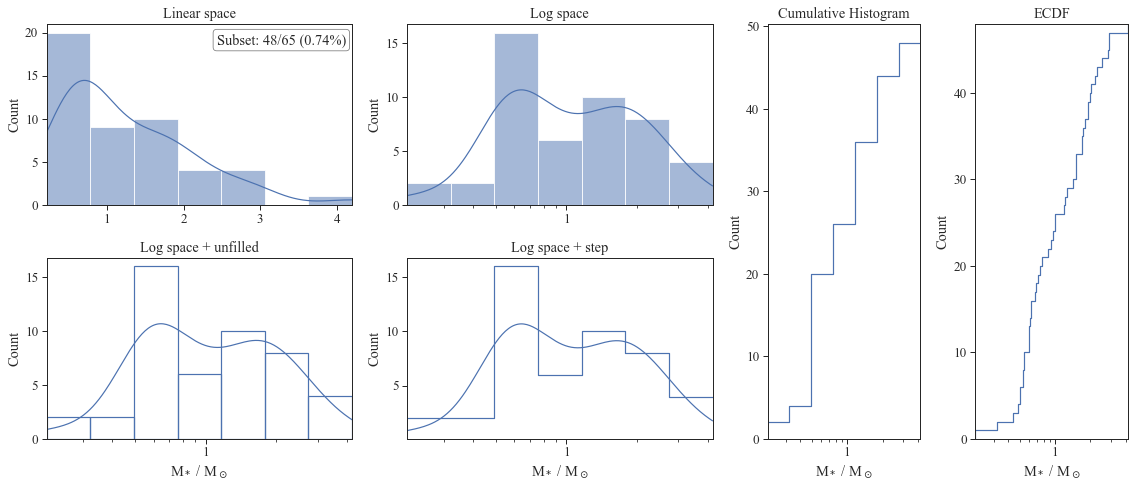

In [5]:
widths = [2, 2, 1, 1]
heights = [1, 1]

fig, [[ax1, ax2, ax3, ax4], 
      [ax5, ax6, ax7, ax8]] = plt.subplots(nrows=2, ncols=4, figsize=(16, 7), 
                                                                 gridspec_kw=dict(width_ratios=widths, height_ratios=heights))
gs = ax3.get_gridspec()

# Remove right column, combine axes
for ax in [ax3, ax7, ax4, ax8]:
    ax.remove()

axbig1 = fig.add_subplot(gs[:, -2])
axbig2 = fig.add_subplot(gs[:, -1])

ax1 = sns.histplot(data=visir, x="Mstar", kde=True, stat='count', log_scale=False, ax=ax1)
finalize_plot(ax1, title='Linear space', xlabel='')
ax1.text(s=f'Subset: {prop_count}/{data_size} ({prop_completeness:.2f}%)', x=0.98, y=0.95, va='top', ha='right', transform=ax1.transAxes,
        bbox={'boxstyle': 'round', 'pad': 0.25, 'facecolor': 'white', 'edgecolor': 'gray'})


ax2 = sns.histplot(data=visir, x="Mstar", kde=True, stat='count', log_scale=True, ax=ax2)
finalize_plot(ax2, log=True, title='Log space', xlabel='')

sns.histplot(data=visir, x="Mstar", kde=True, stat='count', log_scale=True, fill=False, ax=ax5)
finalize_plot(ax5, log=True, title='Log space + unfilled', xlabel='M$_*$ / M$_\odot$')

sns.histplot(data=visir, x="Mstar", kde=True, stat='count', log_scale=True, fill=False, element='step', ax=ax6)
finalize_plot(ax6, log=True, title='Log space + step', xlabel='M$_*$ / M$_\odot$')

sns.histplot(data=visir, x="Mstar", log_scale=True, fill=False, element='step', 
             cumulative=True, stat="count", common_norm=False, ax=axbig1)
finalize_plot(axbig1, log=True, title='Cumulative Histogram', xlabel='M$_*$ / M$_\odot$')

sns.ecdfplot(data=visir, x="Mstar", stat='count', log_scale=False, ax=axbig2)
finalize_plot(axbig2, log=True, title='ECDF', xscale='log', xlabel='M$_*$ / M$_\odot$')

plt.tight_layout()

## Layered Histogram by Molecule

In the next two grids I have changed the distribution visualizations to showcase the different subsets of data based on flux measurements availability. In this case I am doing so by layering different histograms on top of one another, but for different subsets of `Mstar` values: those with H2O measurements, those with Neon measurements, those with neither. This grid follows the same format as before, but now we are layering the subsets. We do the same for the cumulative histogram, and ECDF plot; but in this case they are just curves so it just looks like three curves. A big difference for these two special plots is that I am normalizing the counts so for the cumulative histogram we see the density and for the ECDF we see the proportion of values.

This grid can help us get a sense on how the data is split among the three categories. The histograms are good at informing us how the data is split in numbers, for example we can see the number of H$_2$O fluxes are very low. The cumulative histogram and ECDF plot may be more useful at determining the shape of the distributions, and how the subsets compare to each other.

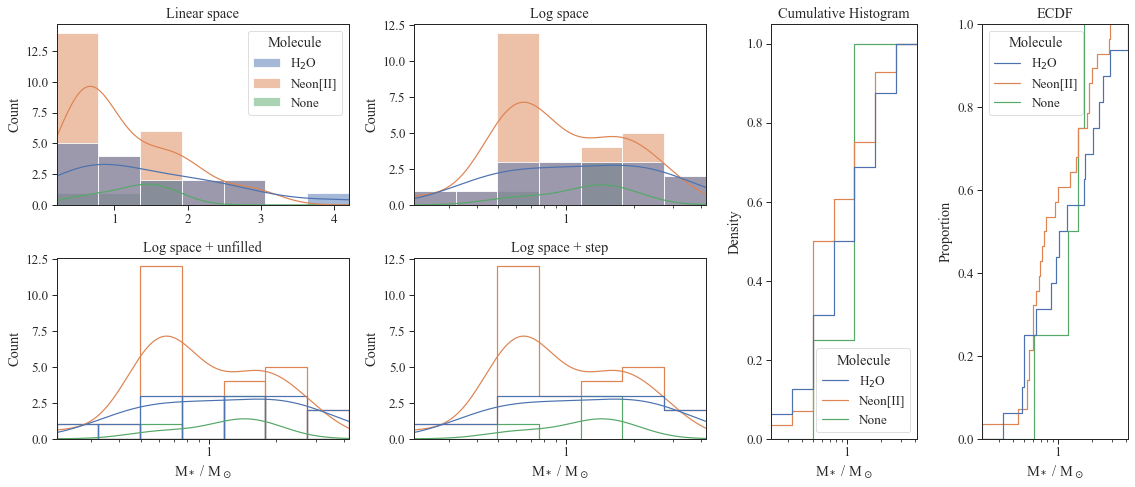

In [7]:
widths = [2, 2, 1, 1]
heights = [1, 1]

fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(nrows=2, ncols=4, figsize=(16, 7), gridspec_kw=dict(width_ratios=widths, height_ratios=heights))
gs = ax3.get_gridspec()

# Remove right column, combine axes
for ax in [ax3, ax7, ax4, ax8]:
    ax.remove()

axbig1 = fig.add_subplot(gs[:, -2])
axbig2 = fig.add_subplot(gs[:, -1])

ax1 = sns.histplot(data=visir, x="Mstar", hue='Molecule', kde=True, stat='count', log_scale=False, ax=ax1)
finalize_plot(ax1, title='Linear space', xlabel='')

ax2 = sns.histplot(data=visir, x="Mstar", hue='Molecule', kde=True, stat='count', log_scale=True, legend=False, ax=ax2)
finalize_plot(ax2, log=True, title='Log space', xlabel='')

sns.histplot(data=visir, x="Mstar", hue='Molecule', kde=True, stat='count', log_scale=True, fill=False, legend=False, ax=ax5)
finalize_plot(ax5, log=True, title='Log space + unfilled', xlabel='M$_*$ / M$_\odot$')

sns.histplot(data=visir, x="Mstar", hue='Molecule', kde=True, stat='count', log_scale=True, fill=False, element='step', legend=False, ax=ax6)
finalize_plot(ax6, log=True, title='Log space + step', xlabel='M$_*$ / M$_\odot$')

sns.histplot(data=visir, x="Mstar", hue='Molecule', log_scale=True, fill=False, element='step', 
             cumulative=True, stat="density", common_norm=False, ax=axbig1)
finalize_plot(axbig1, log=True, title='Cumulative Histogram', xlabel='M$_*$ / M$_\odot$')

sns.ecdfplot(data=visir, x="Mstar", hue='Molecule', log_scale=False, ax=axbig2)
finalize_plot(axbig2, log=True, title='ECDF', xlabel='M$_*$ / M$_\odot$', xscale='log')

plt.tight_layout()

## Stacked Histogram by Molecule

Like in the grid before, we are splitting the data into subsets and visualizing them in different colors. The main difference in this method is that the data gets stacked in the histograms. Not only are the histogram bars stacked, but so are the KDE curves so we can see how each subset contributes to the KDE curves; at least I think this is how it works, I am still confused as to why the KDE look so different from the layered format. Anyways, this is the main difference I guess. The stacked bars also help a bit in decluttering the axes; the layered transparent bars may make it harder to differentiate between subsets. I made no modifications to the cumulative histogram or ECDF plot for this format.

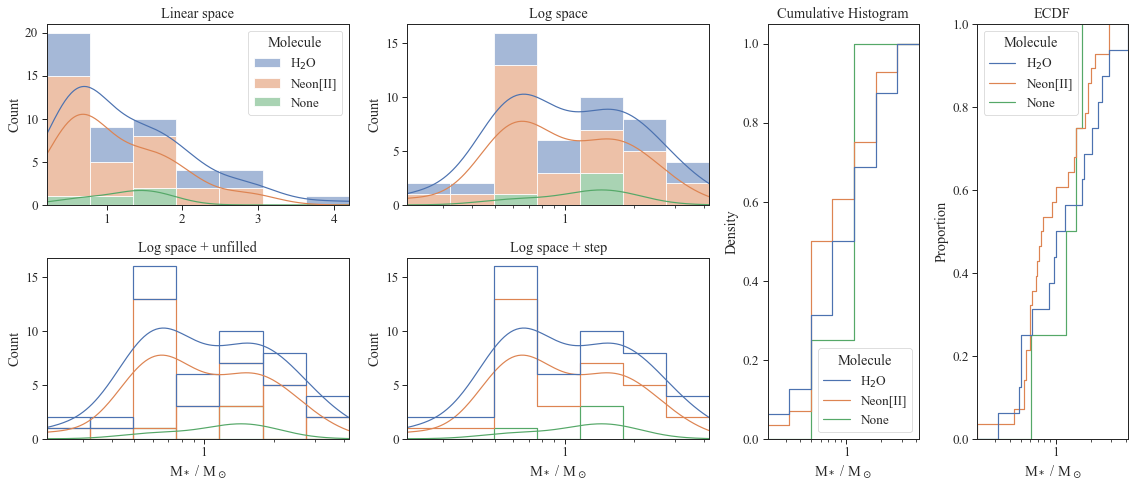

In [8]:
widths = [2, 2, 1, 1]
heights = [1, 1]

fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(nrows=2, ncols=4, figsize=(16, 7), gridspec_kw=dict(width_ratios=widths, height_ratios=heights))
gs = ax3.get_gridspec()

# Remove right column, combine axes
for ax in [ax3, ax7, ax4, ax8]:
    ax.remove()

axbig1 = fig.add_subplot(gs[:, -2])
axbig2 = fig.add_subplot(gs[:, -1])

ax1 = sns.histplot(data=visir, x="Mstar", hue='Molecule', multiple="stack", kde=True, stat='count', log_scale=False, ax=ax1)
finalize_plot(ax1, title='Linear space', xlabel='')

ax2 = sns.histplot(data=visir, x="Mstar", hue='Molecule', multiple="stack", kde=True, stat='count', log_scale=True, legend=False, ax=ax2)
finalize_plot(ax2, log=True, title='Log space', xlabel='')

sns.histplot(data=visir, x="Mstar", hue='Molecule', multiple="stack", kde=True, stat='count', log_scale=True, fill=False, legend=False, ax=ax5)
finalize_plot(ax5, log=True, title='Log space + unfilled', xlabel='M$_*$ / M$_\odot$')

sns.histplot(data=visir, x="Mstar", hue='Molecule', multiple="stack", kde=True, stat='count', log_scale=True, fill=False, element='step', legend=False, ax=ax6)
finalize_plot(ax6, log=True, title='Log space + step', xlabel='M$_*$ / M$_\odot$')

sns.histplot(data=visir, x="Mstar", hue='Molecule', log_scale=True, fill=False, element='step', 
             cumulative=True, stat="density", common_norm=False, ax=axbig1)
finalize_plot(axbig1, log=True, title='Cumulative Histogram', xlabel='M$_*$ / M$_\odot$')

sns.ecdfplot(data=visir, x="Mstar", hue='Molecule', log_scale=False, ax=axbig2)
finalize_plot(axbig2, log=True, title='ECDF', xscale='log', xlabel='M$_*$ / M$_\odot$')

plt.tight_layout()